In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [2]:
torch.manual_seed(1307)

In [3]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

def none_transform():
    transforms = [
        LabelSelect(label_id=1),
        lambda x, y: (x, y.squeeze().type(torch.long))
    ]
    return PairedCompose(transforms)

def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [4]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [5]:
ckpt_dir = None
is3D = False
root_dir = "/disk/scratch_big/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]]
# domains = [ wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]

train_proportion = 0.7
test_proportion = 0.15
validation_proportion = 0.15
seed = 3407

In [6]:
### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size

In [12]:
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [13]:
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [14]:
datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_dataset_3d, val_dataset_3d, test_dataset_3d]]

In [15]:
train_dataset, val_dataset, test_dataset = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

In [16]:
val_dataset[0][1].shape

torch.Size([224, 160])

In [17]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 30, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [18]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [19]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [20]:
def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as transforms

class HmResBlock(nn.Module):
    def __init__(self, channels, p):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=7, stride=1, dilation=2, padding='same')
        self.dropout1 = nn.Dropout2d(p)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, dilation=2, padding='same')
        self.norm2 = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        out = out + identity
        
        return out
    
class DownBlock(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.conv = nn.Conv2d(ins, outs, kernel_size=3, stride=2, dilation=1, padding=1)
        self.norm = nn.InstanceNorm2d(outs)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        return self.activ(self.norm(self.conv(x)))

class HmUpsampBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, dilation=1, padding='same')
        self.norm = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode='bilinear')
        return self.activ(self.norm(self.conv(out)))
        

class HmFeatureBlock(nn.Module):
    def __init__(self, ins):
        super().__init__()
        self.conv1 = nn.Conv2d(ins, ins//2, kernel_size=3, stride=1, dilation=2, padding='same')
        self.activ = nn.ReLU()
        self.norm1 = nn.InstanceNorm2d(ins)
        self.conv2 = nn.Conv2d(ins//2, ins//2, kernel_size=1, stride=1, dilation=1)
        self.norm2 = nn.InstanceNorm2d(ins)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        return out
    
class HyperMapREDO(nn.Module):
    def __init__(self,dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, outchannels=2):
        super().__init__()
        
        
        # input layer
        self.conv_first = nn.Conv2d(inchannels, encoder_sizes[0], kernel_size=5, stride=1, dilation=1, padding='same')
        self.activ = nn.ReLU()
        
        # encoder section
        l = len(encoder_sizes) - 1
        self.down_blocks = nn.ModuleList([
            DownBlock(encoder_sizes[i], encoder_sizes[i+1]) for i in range(0, l)
        ])
        
        self.res_blocks = nn.ModuleList([
            HmResBlock(c, dropout_p) for c in encoder_sizes
        ])
        
        # decoder section
        self.upsample_blocks = nn.ModuleList([
            HmUpsampBlock(c) for c in encoder_sizes[:-1][::-1]
        ])
        
        self.feature_blocks = nn.ModuleList([
            HmFeatureBlock(encoder_sizes[l - i]) for i in range(l-1)
        ])
        
        
        # multi-scale feature section
        self.ms_feature_layers = nn.ModuleList([
            nn.Conv2d(encoder_sizes[2], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        ])
        
        
        # output layer
        self.last_1 = nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        self.last_2 = nn.Conv2d(encoder_sizes[1]*3, encoder_sizes[1], 1)
        self.last_3 = nn.Conv2d(encoder_sizes[1], outchannels, 1)
        self.last_norm = nn.InstanceNorm2d(encoder_sizes[1])
        
    def forward(self, x):
        # input layer
        out = self.activ(self.conv_first(x))
        # print(out.shape)
        
        skips = []
        
        # encoder section
        out = self.res_blocks[0](out)
        # print(out.shape)
        skips.append(out)
        for i in range(len(self.res_blocks) - 1):
            out = self.down_blocks[i](out)
            out = self.res_blocks[i+1](out)
            # print("loop: ", out.shape)
            skips.append(out)
        
        # decoder section
        ml_features = []
        out = skips.pop()
        for i in range(len(self.upsample_blocks)):
            # print("dec")
            if i > 0:
                sk = skips.pop()
                sk = transforms.center_crop(sk, out.shape[-2:])
                out = torch.cat([out, sk], dim=1)
                out = self.feature_blocks[i-1](out)
            
            if i > 1:
                ml_features.append(self.ms_feature_layers[i-2](out))
                
            out = self.upsample_blocks[i](out)
        
        # final layers
        sk = skips.pop()
        sk = transforms.center_crop(sk, out.shape[-2:])
        out = torch.cat([out, sk], dim=1)
        out = self.last_norm(self.activ(self.last_1(out)))
        
        # multiscale feature section
        ml_features = [out] + ml_features
        ml_features = [F.interpolate(mf, size=x.shape[-2:], mode='bilinear') for mf in ml_features]
        combined_features = torch.cat(ml_features, dim=1)
        
        out = self.activ(self.last_2(combined_features))
        out = self.last_3(out)
        
        return out
        

In [22]:
loss = dice_loss

In [23]:
model_raw = HyperMapREDO().cuda()

In [24]:
optimizer_params={"lr":2e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

# model = StandardLitModelWrapper(model_raw, loss, 
#                                 logging_metric= lambda : None,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )

In [29]:
# accelerator="gpu"
# devices=1
# max_epochs=1000
# precision = 32

# rootdir = "/disk/scratch/s2208943/results/new_tests/blarg"
# final_dir = rootdir
# checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=-1, monitor="val_loss", every_n_epochs=5)
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
# trainer = pl.Trainer(
#     callbacks=[checkpoint_callback, early_stop_callback],
#     accelerator=accelerator,
#     devices=devices,
#     max_epochs=max_epochs,
#     precision=precision,
#     default_root_dir=final_dir
# )

In [30]:
from tqdm import tqdm
import difflib
import numpy as np
import os
import SimpleITK as sitk
import scipy.spatial
import seaborn as sns
import pandas as pd

In [31]:
def ndigit(n, x):
    s = str(x)
    ns = "0" * (n - len(s))
    return ns + s

In [32]:
root_model = "/home/s2208943/ipdis/results/revamped_models/"
folders = [f for f in os.listdir(root_model) if "deterministic" in f]

In [33]:
folders

['deterministic_hausdorff',
 'deterministic_tversky09',
 'deterministic_tversky07',
 'deterministic_xent_mean_sum_none',
 'deterministic_xent_mean_sum_bigweight',
 'deterministic_brier_mean_sum',
 'deterministic_avd',
 'deterministic_brier_mean',
 'deterministic_dice',
 'deterministic_xent_mean',
 'deterministic_xent_mean_sum',
 'deterministic_brier_sum',
 'deterministic_xent_sum',
 'deterministic_xent_mean_sum_inverse']

In [34]:
cs = []
for f in folders:
    ckpts = sorted([c for c in os.listdir(root_model+f) if "epoch" in c])
    c = ckpts[-2] # the second from last seems to be the 'best' checkpoint
    cs.append(c)

In [35]:
model_name = "deterministic_test"
root = "./"

### loading a model and predictions for that model

In [36]:
xs3d_ed = []
ys3d_ed = []
for x, y in test_dataset_3d:
    xs3d_ed.append(x)
    ys3d_ed.append(y.squeeze())

In [37]:
def load_model(i, loss):
    f = folders[i]
    c = cs[i]

    model = StandardLitModelWrapper.load_from_checkpoint(root_model + f + "/" + c, model=model_raw, loss=loss, 
                                logging_metric=lambda : None, strict=False).cuda()
    print("checkpoint: ", root_model + f + "/" + c)
    #trainer.validate(model, val_dataloader)
    
    return model

In [38]:
def get_preds(model, xs3d):
    # get predictions for each image
    preds3d = []
    with torch.no_grad():
        for x in tqdm(xs3d, position=0, leave=True):
            pred = model.cuda()(x.swapaxes(0,1).cuda()).cpu()
            preds3d.append(torch.nn.functional.softmax(pred, dim=1))
    
    return preds3d

### Calibration code

In [39]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [40]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [41]:
def calibrate_model(ys3d, preds3d):
    # assess bin counts of p y = 1
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = ys3d[batch_idx].squeeze()
        preds = preds3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        p1s = preds[:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            # if num_elem == 0:
            #     print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t[is_in_bin].sum() / num_elem

            # if torch.isnan(c1_acc):
            #     print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            # if torch.isnan(c1_conf):
            #     print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)
        
    # compute overall calibration bins
    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

    # compute ece
    total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    
    
    return {"bin_confidences":bin_confidences, 
            "bin_accuracies":bin_accuracies,
            "ece":ece,
           }

In [42]:
def calibrate_model_per_individual(ys3d, preds3d):
    # assess bin counts of p y = 1
    individual_calibrations = []
    for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        bins = 10 + 1 # for the 0 bin
        bin_batch_accuracies = [[] for b in range(bins)]
        bin_batch_confidences = [[] for b in range(bins)]
        bin_batch_sizes = [[] for b in range(bins)]
        bin_counts = [0 for b in range(bins)]

        batch_t = ys3d[batch_idx].squeeze()
        preds = preds3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        p1s = preds[:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            # if num_elem == 0:
            #     print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t[is_in_bin].sum() / num_elem

            # if torch.isnan(c1_acc):
            #     print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            # if torch.isnan(c1_conf):
            #     print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)

        # compute overall calibration bins
        bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
        bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
        bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

        # compute ece
        total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
        ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))


        individual_calibrations.append({"bin_confidences":bin_confidences, 
                "bin_accuracies":bin_accuracies,
                "ece":ece,
               })
    return individual_calibrations

### Loading and saving predicted images for this model

In [43]:
# count the voxel lesion percentage
lesion_count = 0
total_count = 0
brain_count = 0
for x, y in val_dataloader:
    lesion_count += y.sum()
    total_count += x[:,0].reshape(-1).shape[0]
    brain_count += x[:,1].sum()



In [44]:
# proportion of image taken up by lesion
print((1 - lesion_count / total_count) * 100, (1- lesion_count / brain_count) * 100)

tensor(99.2301) tensor(98.0015)


In [45]:
# loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1, 90]))
# loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([90,1]))
# loss = torch.nn.CrossEntropyLoss()

def mean_sum_xent(pred, target):
    xent = torch.nn.functional.cross_entropy(pred, target, reduction='none')
    bs = pred.shape[0]
    return xent.view(bs, -1).sum(dim=1).mean(dim=0)
    
loss = mean_sum_xent

In [46]:
# todo: find a bunch of interesting images for these methods to predict on!
i = 8
model = load_model(i, loss).cuda()
#preds = get_preds(model, xs3d_ed)

checkpoint:  /home/s2208943/ipdis/results/revamped_models/deterministic_dice/epoch=37-step=5586.ckpt


### doing post hoc calibration

In [47]:
class fixed_temp_param(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = t
        
    def forward(self, x, from_pred=False):
        if not from_pred:
            with torch.no_grad():
                pred = model.cuda()(x)#['logit_mean']
        else:
            pred = x
            
        t = self.t
        return pred/t
    
    def device(self):
        return self.t.device

In [48]:
class temp_param(nn.Module):
    def __init__(self):
        super().__init__()
        self.t = torch.nn.Parameter(torch.randn((1,)) * 0.25)
        
    def forward(self, x, from_pred=False):
        if not from_pred:
            with torch.no_grad():
                pred = model.cuda()(x)#['logit_mean']
        else:
            pred = x
        
        #t = torch.nn.functional.softplus(self.t)
        #t = self.t.exp() + 4
        t = torch.sigmoid(self.t) * 10.
        return pred/t

In [49]:
class kernel_temp_param(nn.Module):
    def __init__(self):
        super().__init__()
        self.t_kernel1 = nn.Conv2d(2, 4, kernel_size=9, padding='same')
        self.t_kernel2 = nn.Conv2d(4, 1, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        
    def forward(self, x, from_pred=False, return_map=False):
        
        if not from_pred:
            with torch.no_grad():
                pred = model.cuda()(x)#['logit_mean']
        else:
            pred = x
        
        t_map = self.t_kernel1(pred)
        t_map = self.relu(t_map)
        t_map = self.t_kernel2(t_map)
        #t_map = torch.nn.functional.softplus(t_map)
        #t_map = t_map.exp() + 1.
        t_map = torch.sigmoid(t_map) * 10
        # t_map = t_map.unsqueeze(1)
        
        if return_map:
            return t_map
        else:
            return pred / t_map

In [50]:
class combined_kernel_temp_param(nn.Module):
    def __init__(self):
        super().__init__()
        self.t_kernel1 = nn.Conv2d(5, 8, kernel_size=9, padding='same')
        self.t_kernel2 = nn.Conv2d(8, 1, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        
    def forward(self, x, return_map=False):
        
        with torch.no_grad():
            pred = model.cuda()(x)#['logit_mean']

        inp = torch.cat([pred, x], dim=1)
        
        t_map = self.t_kernel1(inp)
        t_map = self.relu(t_map)
        t_map = self.t_kernel2(t_map)
        #t_map = torch.nn.functional.softplus(t_map)
        #t_map = t_map.exp() + 1.
        t_map = torch.sigmoid(t_map) * 10
        # t_map = t_map.unsqueeze(1)
        
        if return_map:
            return t_map
        else:
            return pred / t_map

In [51]:
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

In [52]:
x, y = next(iter(val_dataloader))

In [53]:
dist = model(x.cuda())

In [54]:
scaler = temp_param().cuda()
scaler_kernel = kernel_temp_param().cuda()
scaler_combined = combined_kernel_temp_param().cuda()

In [55]:
scaler_fixed = fixed_temp_param(7).cuda()

In [56]:
# pred = scaler(x.cuda())

In [57]:
def get_model_wrapper(base_model, loss):
    return StandardLitModelWrapper(base_model, loss=loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               ).cuda()

temp_model = get_model_wrapper(scaler, loss)

kernel_temp_model = get_model_wrapper(scaler_kernel, loss)

fixed_temp_model = get_model_wrapper(scaler_fixed, loss)

combined_temp_model = get_model_wrapper(scaler_combined, loss)

In [58]:
model.device

device(type='cuda', index=0)

In [59]:
def get_trainer():
    accelerator="gpu"
    devices=1
    max_epochs=20
    precision = 32
    rootdir = "/disk/scratch_big/s2208943/results/new_tests/blarg"
    final_dir = rootdir

    return pl.Trainer(
        callbacks=None,
        accelerator=accelerator,
        devices=devices,
        max_epochs=max_epochs,
        precision=precision,
        default_root_dir=final_dir
    )

In [60]:
temp_trainer = get_trainer()
temp_trainer.fit(temp_model, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | temp_param | 1     
-------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50

Training: 0it [00:00, ?it/s]

In [61]:
temp_trainer = get_trainer()
temp_trainer.fit(kernel_temp_model, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | kernel_temp_param | 689   
--------------------------------------------
689       Trainable params
0         Non-trainable params
689       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [62]:
temp_trainer = get_trainer()
temp_trainer.fit(combined_temp_model, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | combined_kernel_temp_param | 3.3 K 
-----------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [63]:
x, y = next(iter(val_dataloader))

In [64]:
# for x,y in val_dataloader:    
#     with torch.no_grad():
#         p = model.cuda()(x.cuda())
#         print(torch.nn.functional.cross_entropy(p, y.cuda()))

In [65]:
# torch.nn.functional.cross_entropy(p, y)

In [66]:
models = {
    "standard model":model,
    "fixed value model":fixed_temp_model,
    "learned model":temp_model,
    "kernel model":kernel_temp_model,
    "kernel i/o model": combined_temp_model
}

In [67]:
# using the trained model
for name, m in models.items():
    print(name)
    temp_trainer.validate(m, val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


standard model


/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1846.2222900390625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fixed value model


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             700.5394897460938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
learned model


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             509.5391540527344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
kernel model


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             494.2626037597656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
kernel i/o model


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            401.79779052734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [68]:
def get_preds(model, xs3d):
    # get predictions for each image
    preds3d = []
    with torch.no_grad():
        for x in tqdm(xs3d, position=0, leave=True):
            pred = model.cuda()(x.swapaxes(0,1).cuda()).cpu()
            preds3d.append(torch.nn.functional.softmax(pred, dim=1))
    
    return preds3d

In [69]:
model_calibs = {}
model_ind_calibs = {}

for name, m in models.items():
    preds = get_preds(m, xs3d_ed)
    calib_data = calibrate_model(ys3d_ed, preds)
    ind_calib_data = calibrate_model_per_individual(ys3d_ed, preds)
    
    model_calibs[name] = calib_data
    model_ind_calibs[name] = ind_calib_data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.25it/s]


In [72]:
plt.style.use('fivethirtyeight')


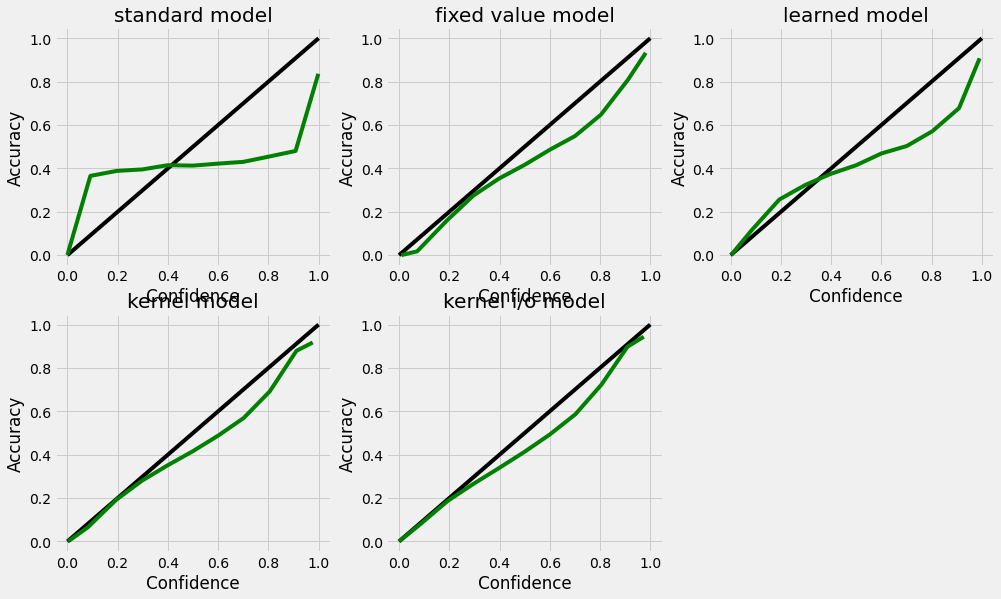

In [73]:
plt.figure(figsize=(15, 9))

for i, name in enumerate(models.keys()):
    results = model_calibs[name]
    plt.subplot(2, 3, i+1)
    plt.plot([0,1],[0,1], c='black');
    plt.plot(results['bin_confidences'], results['bin_accuracies'], c='g')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy");
    plt.title(name)

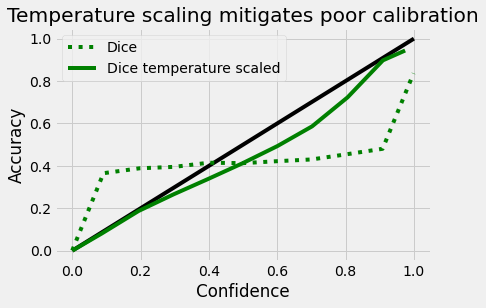

In [81]:
name = "standard model"
results = model_calibs[name]
plt.plot([0,1],[0,1], c='black');
plt.plot(results['bin_confidences'], results['bin_accuracies'], ':', c='g', label="Dice")
plt.xlabel("Confidence")
plt.ylabel("Accuracy");


name = "kernel i/o model"
results = model_calibs[name]
#plt.plot([0,1],[0,1], c='black');
plt.plot(results['bin_confidences'], results['bin_accuracies'], c='g', label="Dice temperature scaled")
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
plt.title("Temperature scaling mitigates poor calibration")
plt.legend();

Text(0.5, 1.0, 'Calibration per individual image')

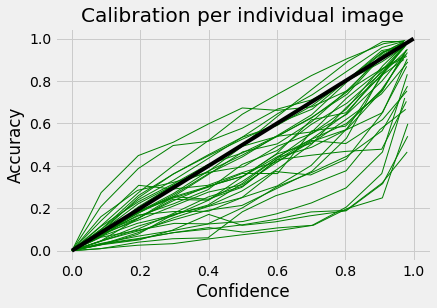

In [84]:
results_list = model_ind_calibs['kernel i/o model']
#plt.subplot(2, 3, i+1)
for results in results_list:
    plt.plot(results['bin_confidences'], results['bin_accuracies'], c='g', linewidth=1)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy");
plt.plot([0,1],[0,1], c='black');
plt.title("Calibration per individual image")

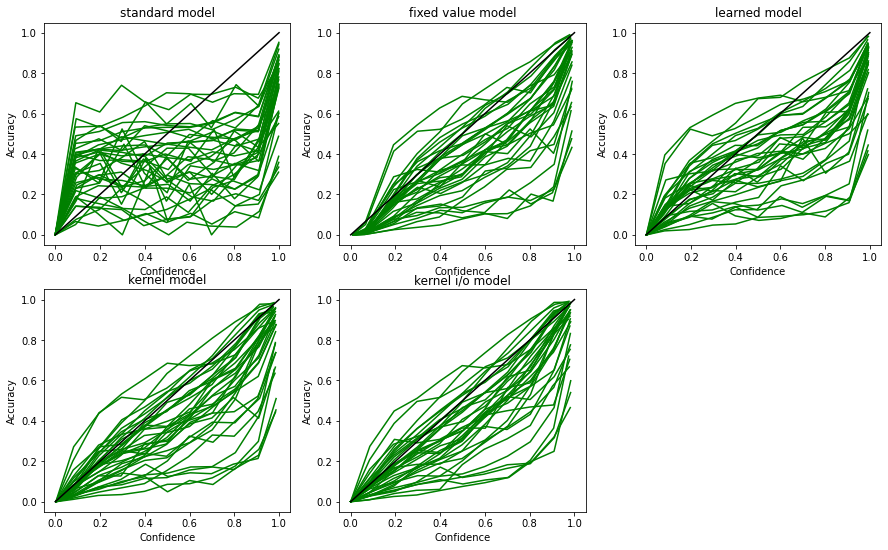

In [71]:
plt.figure(figsize=(15, 9))

for i, name in enumerate(models.keys()):
    results_list = model_ind_calibs[name]
    plt.subplot(2, 3, i+1)
    for results in results_list:
        plt.plot(results['bin_confidences'], results['bin_accuracies'], c='g')
        plt.xlabel("Confidence")
        plt.ylabel("Accuracy");
    plt.plot([0,1],[0,1], c='black');
    plt.title(name)

### plot ece vs lesion burden

In [85]:
burdens = []
for y in ys3d_ed:
    burdens.append(y.sum())

Text(0, 0.5, 'Expected calibration Error')

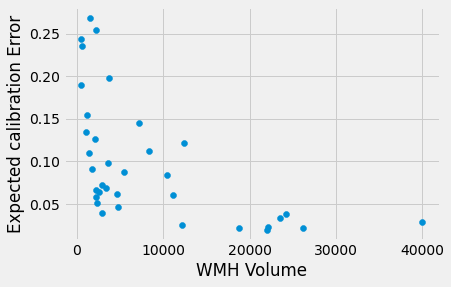

In [88]:
plt.scatter(burdens, [r['ece'] for r in model_ind_calibs['kernel i/o model']])
plt.xlabel("WMH Volume")
plt.ylabel("Expected calibration Error")

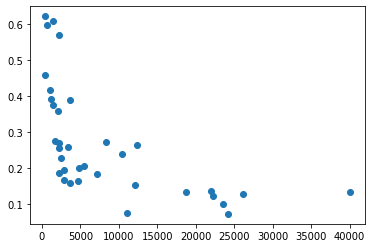

In [334]:
plt.scatter(burdens, [r['ece'] for r in model_ind_calibs['standard model']])

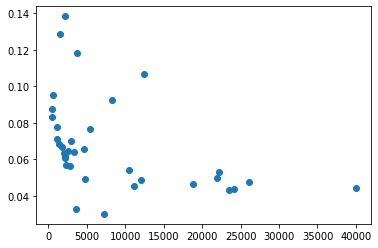

In [335]:
plt.scatter(burdens, [r['ece'] for r in model_ind_calibs['fixed value model']])

In [332]:
model_ind_calibs['kernel i/o model']

[{'bin_confidences': [0.00040305170114152133,
   0.08577916771173477,
   0.194314643740654,
   0.29723483324050903,
   0.3984590768814087,
   0.49937695264816284,
   0.598630428314209,
   0.6995417475700378,
   0.8012118935585022,
   0.908535361289978,
   0.9813015460968018],
  'bin_accuracies': [0.00023566081654280424,
   0.03390399366617203,
   0.05027322471141815,
   0.0962962955236435,
   0.10098522156476974,
   0.11746987700462341,
   0.1597222238779068,
   0.17182131111621857,
   0.1766381710767746,
   0.33125001192092896,
   0.46666666865348816],
  'ece': tensor(0.2642)},
 {'bin_confidences': [0.0005757337785325944,
   0.08824410289525986,
   0.19569824635982513,
   0.2974774241447449,
   0.3984886705875397,
   0.4997415840625763,
   0.60167396068573,
   0.7032106518745422,
   0.8073463439941406,
   0.9069660305976868,
   0.9719066023826599],
  'bin_accuracies': [0.0006102673942223191,
   0.10617940127849579,
   0.24343065917491913,
   0.3329479694366455,
   0.44121813774108887,

In [403]:
with torch.no_grad():
    pred = model(x.to(model.device)).cpu()
    tmap = temp_model(pred.to(temp_model.device), from_pred=True, return_map=True).cpu()

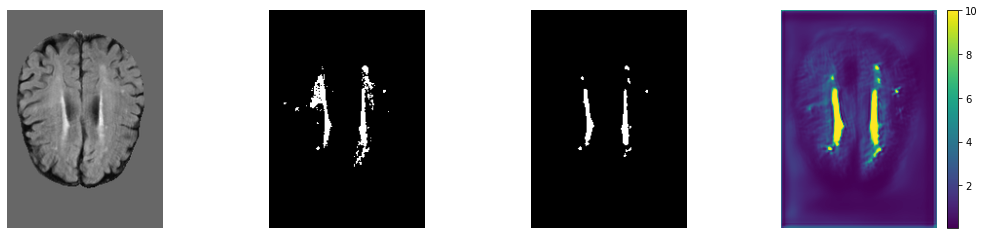

In [404]:

islice = 28
plt.figure(figsize=(18, 4))
plt.subplot(1,4,1)
plt.imshow(x[islice][0], cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y[islice], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(pred[islice].argmax(dim=0), cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(tmap[islice].squeeze()); plt.axis('off')
plt.colorbar()